In [1]:
import math
import re
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angela/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
cd src

/Users/angela/diversity-colleges/src


In [7]:
import sys
sys.path.append('src')
import ouraws

In [8]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [53]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="middlebury"
SUBJECT="opinion"
START_YEAR=2001
FINAL_YEAR=2022

In [65]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [55]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [56]:
diversity_pattern = "\b" + "|".join(diversity_lemmas) + "\b"
text = "This is an inclusive and multi-cultural center that focuses on equality and racial justice."
len(re.findall(diversity_pattern, text))

4

In [57]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    '''Clean & prep text (numpy.Series): lowercase, lemmatize, stopword'''
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split() 
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text)) 
                                 for text in text_series])
    return text_series, total_diversity_words

In [58]:
%pwd

'/Users/angela/diversity-colleges'

In [59]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [60]:
df.shape

(2984, 4)

In [61]:
df.columns

Index(['url', 'body', 'year', 'month'], dtype='object')

In [62]:
df.head(5)

,url,body,year,month
0,https://www.middleburycampus.com/article/2022/...,"\nIn a couple of weeks, the last class who has...",2022,5
1,https://www.middleburycampus.com/article/2023/...,\nDeep breath. I turn on my phone and go to op...,2023,1
2,https://www.middleburycampus.com/article/2023/...,"\nOn Jan. 1, among other visitors and groups o...",2023,1
3,https://www.middleburycampus.com/article/2023/...,"\nWith few Covid-19 guidelines still in place,...",2023,1
4,https://www.middleburycampus.com/article/2023/...,\nIf you’ve read some of our recent editorials...,2023,1


In [63]:
df["year"].unique()

array([2022, 2023, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2003, 2002, 2001])

In [67]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    if year == 2004:
        continue 
        
    year_df = df[df.year==year]

    clean_df, num_diversity_words = prepText(year_df.body)    
    wv = [nlp(s) for s in clean_df]
        
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2], 
              'norm-2':   cov[3], 
              'norm-inf': cov[4], 
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
              }
    results.append(result)


2001, 46, 1.9021220952491071, 0.07724604203292906
2002, 180, 1.8776131350957475, 0.11816454810660895
2003, 137, 1.8562876088034015, 0.06876704294585473
2005, 158, 1.747662794118706, 0.07885976418398336
2006, 172, 1.7715684330934904, 0.11725799482429865
2007, 164, 1.799666305104551, 0.1060352610795493
2008, 225, 1.9201046883242396, 0.15255481180940833
2009, 128, 1.9262012082090338, 0.16090660690778297
2010, 151, 1.9126229587735928, 0.0928083370348822
2011, 95, 1.9229260622430544, 0.08559484279905412
2012, 103, 1.967517066273695, 0.08586633860252048
2013, 213, 2.0190247375423747, 0.08275131520026975
2014, 175, 2.0160549006328767, 0.08110629739083408
2015, 174, 2.05374167673795, 0.06926946400369696
2016, 59, 2.092100811576163, 0.07404633037936949
2017, 125, 1.977277878236996, 0.07613002804563457
2018, 152, 1.9908763394080877, 0.08916094709126293
2019, 171, 1.9808489617157188, 0.08446064652186368
2020, 154, 1.9657211899959741, 0.06468512416774111
2021, 78, 1.9766350154787726, 0.08465363363

In [68]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2001,0.077246,46,1.902122,1.995600,1.761962,1.995600,6,0.130435
2002,0.118165,180,1.877613,1.918193,1.655655,1.918193,28,0.155556
2003,0.068767,137,1.856288,1.986148,1.734006,1.986148,20,0.145985
2005,0.078860,158,1.747663,1.912248,1.614191,1.912248,10,0.063291
2006,0.117258,172,1.771568,1.812345,1.567404,1.812345,14,0.081395
2007,0.106035,164,1.799666,1.880902,1.613088,1.880902,11,0.067073
2008,0.152555,225,1.920105,1.833663,1.586238,1.833663,20,0.088889
2009,0.160907,128,1.926201,1.928044,1.580983,1.928044,26,0.203125
2010,0.092808,151,1.912623,2.067177,1.745266,2.067177,17,0.112583


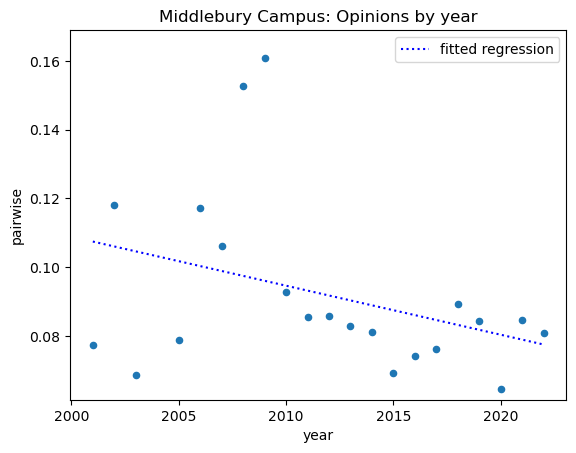

In [69]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Middlebury Campus: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()


mentions-norm slope:0.03911, int:0.00398, r:0.71724, p:0.00025, se:0.00872, x:range(0, 21)
pairwise slope:-0.00155, int:0.10743, r:-0.37318, p:0.09567, se:0.00088, x:range(0, 21)
trace slope:0.00993, int:1.83622, r:0.69766, p:0.00044, se:0.00234, x:range(0, 21)
norm-1 slope:0.01244, int:1.90953, r:0.64413, p:0.00163, se:0.00339, x:range(0, 21)
norm-2 slope:0.01258, int:1.63434, r:0.68410, p:0.00063, se:0.00308, x:range(0, 21)
norm-inf slope:0.01244, int:1.90953, r:0.64413, p:0.00163, se:0.00339, x:range(0, 21)


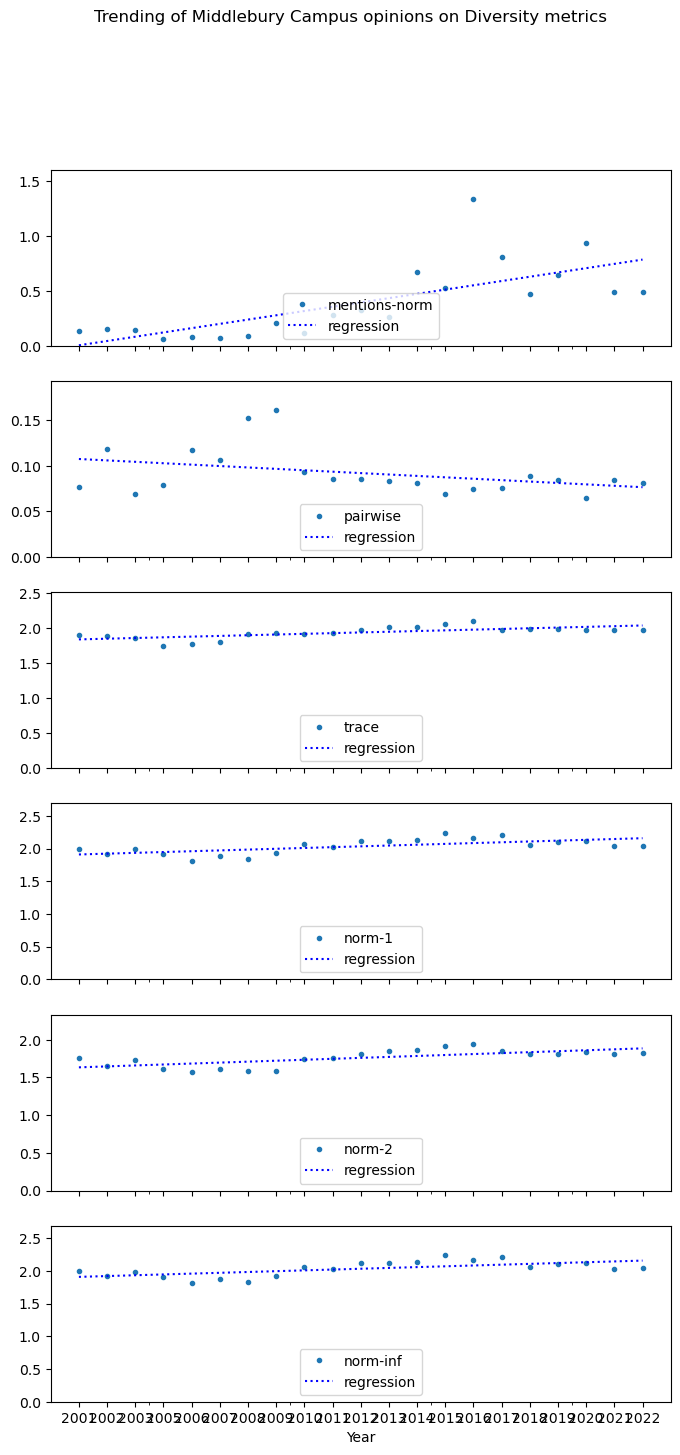

In [70]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8,16))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Middlebury Campus opinions on Diversity metrics")
plt.show()

mentions-norm slope:0.03911, int:0.00398, r:0.71724, p:0.00025, se:0.00872, x:range(0, 21)
pairwise slope:-0.00155, int:0.10743, r:-0.37318, p:0.09567, se:0.00088, x:range(0, 21)


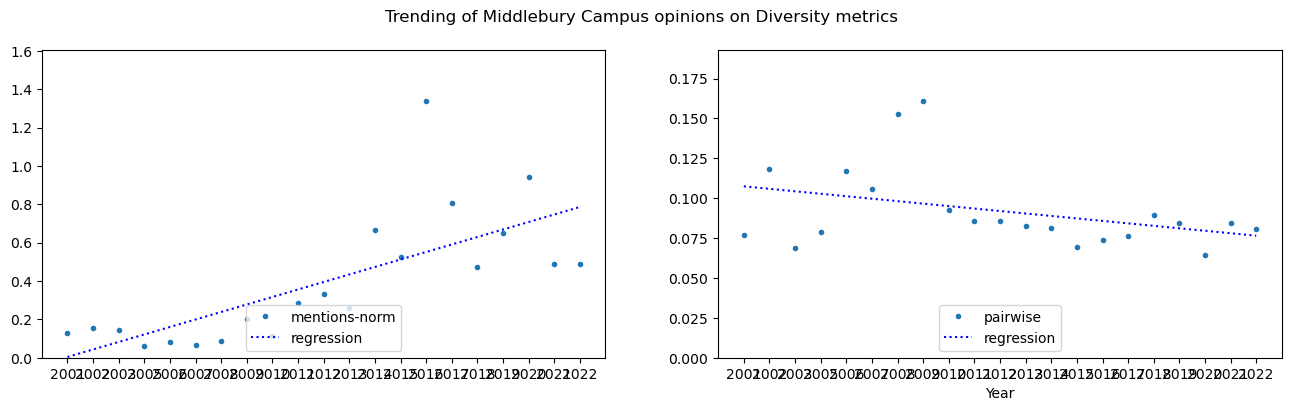

In [74]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Middlebury Campus opinions on Diversity metrics")
plt.show()